# Digit Recognizer

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

train_df = pd.read_csv('./data/train.csv', sep=',')
train_df.head()
print(train_df.shape)
print(len(train_df))

(42000, 785)
42000


In [4]:
X_train = train_df.drop(labels=['label'], axis=1)
y_train = train_df['label']

y_train.head()

0    1
1    0
2    1
3    4
4    0
Name: label, dtype: int64

In [ ]:
x = X_train.iloc[0]
x_np = np.array(x)
print(f'Previous shape = {x_np.shape}')
x_np = np.resize(x_np, (28, 28))
print(f'New shape = {x_np.shape}')
print(x_np)

Previous shape = (784,)
New shape = (28, 28)
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0 188 255  94   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0 191 250 253  93   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
  123 248 253 167  10   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  80
  247 253 208  13   0   0   0   0   0   0]
 [  0   0   0   0  

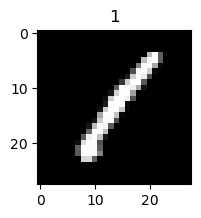

In [13]:
fig = plt.figure(figsize=(2, 2))
ax = fig.add_subplot(1, 1, 1)
ax.imshow(x_np, cmap='gray')
ax.set_title(y_train[0])
plt.show()

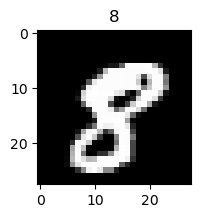

In [16]:
def show_digit(sample):
    """Show digit from pixels."""
    x, y = sample.drop('label'), sample['label']
    x_np = np.asarray(x, dtype=np.float32).reshape(28, 28)
    fig = plt.figure(figsize=(2, 2))
    ax = fig.add_subplot(1, 1, 1)
    ax.imshow(x_np, cmap='gray')
    ax.set_title(y)
    plt.show()

show_digit(train_df.iloc[10])

## Creating the Dataloader

In [89]:
import os
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, utils

import warnings
warnings.filterwarnings('ignore')

plt.ion()  # interactive mode


class DigitDataset(Dataset):
    """Digit dataset."""

    def __init__(self, root, train, transform=None):
        self.csv_path = os.path.join(
            root, 'train.csv') if train else os.path.join(root, 'test.csv')
        self.data = pd.read_csv(self.csv_path, sep=',')
        self.transform = transform
        self.train = train

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        sample = self.data.iloc[idx]

        if self.train:
            img, label = sample.drop('label'), sample['label']
            img = np.asarray(img, dtype=np.float32).reshape(28, 28)

            if self.transform:
                img = self.transform(img)
            return img, label
        else:
            img = np.asarray(sample, dtype=np.float32).reshape(28, 28)

            if self.transform:
                img = self.transform(img)
            return img

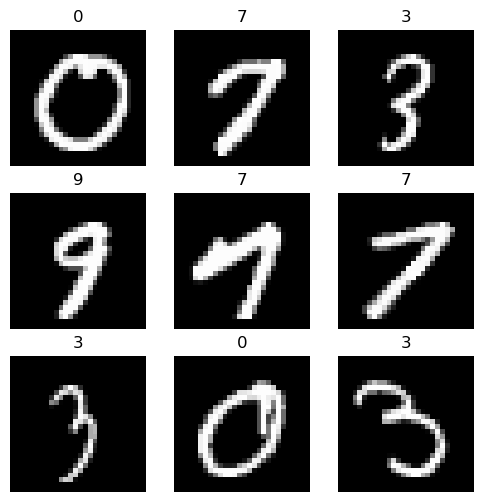

In [96]:
digits_train = DigitDataset(
    root='data',
    train=True
)

fig = plt.figure(figsize=(6, 6))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(digits_train), size=(1, )).item()
    img, label = digits_train[sample_idx]
    ax = fig.add_subplot(rows, cols, i)
    plt.axis('off')
    ax.set_title(label=str(label))
    ax.imshow(img, cmap='gray') # type: ignore
plt.show()

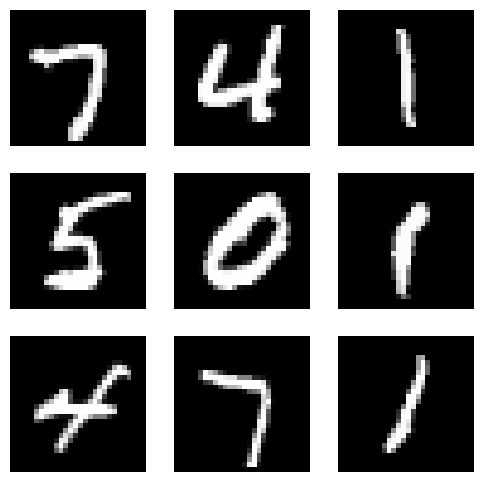

In [95]:
digits_train = DigitDataset(
    root='data',
    train=False
)

fig = plt.figure(figsize=(6, 6))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(digits_train), size=(1, )).item()
    img = digits_train[sample_idx]
    ax = fig.add_subplot(rows, cols, i)
    plt.axis('off')
    ax.imshow(img, cmap='gray') # type: ignore
plt.show()